In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


In [14]:
# additional imports

import ast
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
from datetime import date, datetime

import warnings
warnings.simplefilter("ignore", UserWarning)

In [15]:
# load data

df_train = pd.read_csv("input/train.csv")

df_test = pd.read_csv("input/test.csv")
df_test['revenue'] = np.nan

df = pd.concat([df_train, df_test]).reset_index(drop = True)
del df_train, df_test

print(df.shape)
df.head()

(7398, 23)


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651.0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435.0
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000.0
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000.0
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970.0


In [16]:
# show null counts

pd.DataFrame(df.isnull().sum(), columns=['null_count']).sort_values(by='null_count', ascending = False)

,null_count
belongs_to_collection,5917
homepage,5032
revenue,4398
tagline,1460
Keywords,669
production_companies,414
production_countries,157
spoken_languages,62
crew,38
cast,26


In [17]:
# filling null values

df['belongs_to_collection'].fillna(value="", inplace = True)
df.loc[df['title'].isnull(), 'title'] = df.loc[df['title'].isnull(), 'original_title']
df['overview'].fillna(value="", inplace = True)
df['tagline'].fillna(value="", inplace = True)
df['status'].fillna(value = df['status'].mode()[0], inplace = True)

# fill runtime based on info found at https://www.imdb.com
df.loc[df['title']=='Happy Weekend', 'runtime'] = 81
df.loc[df['title']=='Miesten välisiä keskusteluja', 'runtime'] = 90
df.loc[df['title']=='Nunca en horas de clase', 'runtime'] = 100
df.loc[df['title']=='Pancho, el perro millonario', 'runtime'] = 91
df.loc[df['title']=='La caliente niña Julietta', 'runtime'] = 93
df.loc[df['title']=='Королёв', 'runtime'] = 130

# release date of Jails, Hospitals & Hip-Hop movie : May 2000
df.loc[df['release_date'].isnull(), 'release_date'] = '5/1/00'

In [18]:
# make additional features

df['is_onetitle'] = (df['title']==df['original_title']).astype(np.int8)
df['has_homepage'] = df['homepage'].apply(lambda x : 0 if pd.isnull(x) else 1)

# get release year / month
df['release_year'] = df['release_date'].apply(lambda x : x.split('/')[-1])
df['release_month'] = df['release_date'].apply(lambda x : x.split('/')[0]).astype('int')
df['release_date'] = df['release_date'].apply(lambda x : ('19' if x.split('/')[-1] > '19' else '20') + x.split('/')[-1] + x.split('/')[0].zfill(2) + x.split('/')[1].zfill(2)).astype('int')

df['title_words_num'] = df['title'].apply(lambda x : len(x.split(' ')))
df['overview_words_num'] = df['title'].apply(lambda x : len(x.split(' ')))
df['tagline_words_num'] = df['title'].apply(lambda x : len(x.split(' ')))

df['title_length'] = df['title'].apply(lambda x : len(x))
df['overview_length'] = df['overview'].apply(lambda x : len(x))
df['tagline_length'] = df['tagline'].apply(lambda x : len(x))

# get collection id
df['belongs_to_collection'] = df['belongs_to_collection'].astype(str)
df['collection_id'] = df['belongs_to_collection'].apply(lambda x : int(ast.literal_eval(x[1:-1])['id']) if len(x)>0 else np.nan)

temp = df.groupby('collection_id').agg({'id':'count'})
temp.columns = ['collection_cnt']
df = df.merge(temp.reset_index(), how='left', on='collection_id')

temp = df.loc[~df['collection_id'].isnull(), ['id', 'collection_id', 'release_date']]
temp['collection_seq'] = temp.groupby(['collection_id'])['release_date'].rank(method='first')
df = df.merge(temp[['id', 'collection_seq']], how='left', on='id')

df.drop(['homepage'
         , 'poster_path'
         , 'original_title'
         , 'imdb_id'
         , 'belongs_to_collection'
        ], axis = 1, inplace = True)

df.head()

,id,budget,genres,original_language,overview,popularity,production_companies,production_countries,release_date,runtime,...,release_month,title_words_num,overview_words_num,tagline_words_num,title_length,overview_length,tagline_length,collection_id,collection_cnt,collection_seq
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",en,"When Lou, who has become the ""father of the In...",6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",20150220,93.0,...,2,5,5,5,22,155,52,313576.0,2.0,2.0
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,Mia Thermopolis is now a college graduate and ...,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",20040806,113.0,...,8,6,6,6,40,393,60,107674.0,2.0,2.0
2,3,3300000,"[{'id': 18, 'name': 'Drama'}]",en,"Under the direction of a ruthless instructor, ...",64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",20141010,105.0,...,10,1,1,1,8,130,47,NaN,NaN,NaN
3,4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",hi,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",20120309,122.0,...,3,1,1,1,7,581,0,NaN,NaN,NaN
4,5,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",ko,Marine Boy is the story of a former national s...,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",20090205,118.0,...,2,2,2,2,10,168,0,NaN,NaN,NaN


In [19]:
# encoding categorical info columns

encoding_cols = ['genres', 'production_countries', 'production_companies', 'spoken_languages', 'Keywords', 'cast', 'crew']
encoding_ids  = ['id', 'iso_3166_1', 'id', 'iso_639_1', 'id', 'id', 'id']
do_encode     = [True, True, True, True, False, False , False]
cnt_threshold = [2, 50, 63, 25, 50, 50, 50]

encoding_dict = dict()

df['keyword'] = np.nan
df['director'] = np.nan
df['writer'] = np.nan
df['cast_gender_0'] = 0
df['cast_gender_1'] = 0
df['cast_gender_2'] = 0

for e_col, e_id  in zip(encoding_cols, encoding_ids) :
    rows = df[e_col].values
    id_dict = dict()
    cnt_dict = dict()
    for i, row in enumerate(rows) :
        if pd.isnull(row) : continue
        splits = row[1:-1].split('},')
        
        cast_id = ""
        cast_gender = [0, 0, 0]
        
        for j, s in enumerate(splits) :
            if s == "" : continue
            s = (s+'}').replace('}}', '}').replace(' ', '')
            s = ast.literal_eval(s)
            id_dict[s[e_id]] = s['name']
            if s[e_id] not in cnt_dict :
                cnt_dict[s[e_id]] = 0
            cnt_dict[s[e_id]] += 1
            
            if e_col == 'Kewords' and j == 0  :
                df.loc[i, 'keyword'] = s['id']
            elif e_col == 'cast' :
                cast_gender[s['gender']] += 1
            elif e_col == 'crew' :
                if s['job'] == 'Director' :
                    df.loc[i, 'director'] = s['id']
                elif s['job'] == 'Writer' :
                    df.loc[i, 'writer'] = s['id']
                
        if e_col == 'cast' :
            df.loc[i, 'cast_gender_0'] = cast_gender[0]
            df.loc[i, 'cast_gender_1'] = cast_gender[1]
            df.loc[i, 'cast_gender_2'] = cast_gender[2]
                
    encoding_dict[e_col] = [id_dict, cnt_dict]
    
# reduce category dim based on count
for (k, i), t in zip(encoding_dict.items(), cnt_threshold) :
    print(k, len(i[0]))
    prune_id = [k_ for k_, i_ in i[1].items() if i_ < t]
    print("reduced", len(i[0]) - len(prune_id))
    for p in prune_id :
        del i[0][p]
        del i[1][p]

genres 20
reduced 19
production_countries 98
reduced 17
production_companies 7139
reduced 23
spoken_languages 98
reduced 24
Keywords 11930
reduced 116
cast 76584
reduced 15
crew 69733
reduced 57


In [20]:
for e_col, e_id, do in zip(encoding_cols, encoding_ids, do_encode) :
    df[e_col + '_cnt'] = 1
    if do : 
        for k, i in encoding_dict[e_col][0].items() :
            df[e_col + '_' + i] = 0
        df[e_col + '_etc'] = 0
    rows = df[e_col].values
    for i, row in enumerate(rows) :
        if pd.isnull(row) : continue
        splits = row[1:-1].split('},')
        df.loc[i, e_col + '_cnt'] = len(splits)
        if do : 
            col_names = []
            etc_name = 0
            for s in splits :
                if s == "" : continue
                s = (s+'}').replace('}}', '}').replace(' ', '')
                s = ast.literal_eval(s)
                if s[e_id] in encoding_dict[e_col][0] and s['name'] not in col_names :
                    col_names.append(s['name'])
                    etc_name = 1
            df.loc[i, [e_col + '_' + name for name in col_names]] = 1
            df.loc[i, e_col + '_etc'] = etc_name
                
df.drop(encoding_cols, axis = 1, inplace = True)
df.head()

,id,budget,original_language,overview,popularity,release_date,runtime,status,tagline,title,...,spoken_languages_Polski,spoken_languages_Türkçe,spoken_languages_Magyar,spoken_languages_ελληνικά,spoken_languages_ภาษาไทย,spoken_languages_Dansk,spoken_languages_etc,Keywords_cnt,cast_cnt,crew_cnt
0,1,14000000,en,"When Lou, who has become the ""father of the In...",6.575393,20150220,93.0,Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,...,0,0,0,0,0,0,1,4,24,72
1,2,40000000,en,Mia Thermopolis is now a college graduate and ...,8.248895,20040806,113.0,Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,...,0,0,0,0,0,0,1,4,20,9
2,3,3300000,en,"Under the direction of a ruthless instructor, ...",64.299990,20141010,105.0,Released,The road to greatness can take you to the edge.,Whiplash,...,0,0,0,0,0,0,1,12,51,64
3,4,1200000,hi,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,20120309,122.0,Released,,Kahaani,...,0,0,0,0,0,0,1,7,7,3
4,5,0,ko,Marine Boy is the story of a former national s...,1.148070,20090205,118.0,Released,,Marine Boy,...,0,0,0,0,0,0,1,1,4,2


In [21]:
unique_id = 'id'
target = 'revenue'
random_seed = 2019

train_idx = df[~df[target].isnull()].index.values
test_idx = df[df[target].isnull()].index.values

k = 10
fold = list(KFold(k, shuffle = True, random_state = random_seed).split(train_idx))

In [22]:
def get_model_result(param, features, verbose = 200) :
    predict = np.zeros(test_idx.shape[0])
    err_vals = []
    feature_imp = pd.DataFrame({'feature':[],'gain':[]})

    for i, (trn, val) in enumerate(fold) :
        
        trn = train_idx[trn]
        val = train_idx[val]

        record = dict()
        model = lgb.train(param
                          , lgb.Dataset(df.loc[trn, features], df.loc[trn, target].apply(lambda x : np.log1p(x)))
                          , num_boost_round = 10000
                          , valid_sets = [lgb.Dataset(df.loc[val, features], df.loc[val, target].apply(lambda x : np.log1p(x)))]
                          , verbose_eval = verbose
                          , early_stopping_rounds = 500
                          , callbacks = [lgb.record_evaluation(record)]
                         )
        err_vals.append(record['valid_0']['rmse'][np.argmin(np.array(record['valid_0']['rmse']))])
        feature_imp = pd.concat([feature_imp, pd.DataFrame([(f, imp) for f, imp in zip(features, model.feature_importance('gain'))], columns=['feature', 'gain'])])
        predict += model.predict(df.loc[test_idx, features], num_iteration = model.best_iteration).reshape(-1)
    imp = feature_imp.groupby('feature').agg({'gain':'mean'}).sort_values(by='gain', ascending=False).reset_index()
    return predict, sum(err_vals) / len(err_vals), imp

In [23]:
param = {'objective':'regression',
         'num_leaves' : 30,
         'min_data_in_leaf' : 20,
         'max_depth' : 5,
         'learning_rate': 0.01,
         "metric": 'rmse',
         "random_state" : random_seed,
         "lambda_l1" : 0.01,
         "verbosity": -1}

cat_cols = ['original_language'
            ,'status'
            #,'is_onetitle'
            ,'has_homepage'
            ,'collection_id'
            #,'cast_id'
            ,'director'
            ,'writer'
            ,'keyword']
df[cat_cols] = df[cat_cols].astype('category')
param['categorical_feature'] = cat_cols

features = ['budget','popularity','runtime','release_date'
    ,'release_month'
    ,'collection_cnt'
    #,'collection_seq'
    ,'production_countries_cnt'
    ,'title_words_num'
    ,'overview_words_num'
    ,'tagline_words_num'
    #,'title_length'
    ,'overview_length'
    #,'tagline_length'
    #,'genres_cnt'
    ,'production_companies_cnt'
    ,'spoken_languages_cnt'
    ,'cast_cnt'
    ,'crew_cnt'
    ,'cast_gender_0'
    #,'cast_gender_1'
    #,'cast_gender_2'
] + cat_cols

for col, do in zip(encoding_cols, do_encode) :
    if do :
        features += [col + '_' + i for k, i in encoding_dict[col][0].items()]
    
features

['budget',
 'popularity',
 'runtime',
 'release_date',
 'release_month',
 'collection_cnt',
 'production_countries_cnt',
 'title_words_num',
 'overview_words_num',
 'tagline_words_num',
 'overview_length',
 'production_companies_cnt',
 'spoken_languages_cnt',
 'cast_cnt',
 'crew_cnt',
 'cast_gender_0',
 'original_language',
 'status',
 'has_homepage',
 'collection_id',
 'director',
 'writer',
 'keyword',
 'genres_Comedy',
 'genres_Drama',
 'genres_Family',
 'genres_Romance',
 'genres_Thriller',
 'genres_Action',
 'genres_Animation',
 'genres_Adventure',
 'genres_Horror',
 'genres_Documentary',
 'genres_Music',
 'genres_Crime',
 'genres_ScienceFiction',
 'genres_Mystery',
 'genres_Foreign',
 'genres_Fantasy',
 'genres_War',
 'genres_Western',
 'genres_History',
 'production_countries_UnitedStatesofAmerica',
 'production_countries_India',
 'production_countries_SouthKorea',
 'production_countries_Canada',
 'production_countries_UnitedKingdom',
 'production_countries_Germany',
 'productio

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 2.19052
[1000]	valid_0's rmse: 2.17357
[1500]	valid_0's rmse: 2.15278
[2000]	valid_0's rmse: 2.13154
[2500]	valid_0's rmse: 2.13139
Early stopping, best iteration is:
[2141]	valid_0's rmse: 2.12529
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.88279
Early stopping, best iteration is:
[444]	valid_0's rmse: 1.88169
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 2.18421
Early stopping, best iteration is:
[295]	valid_0's rmse: 2.16755
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.94676
[1000]	valid_0's rmse: 1.92988
[1500]	valid_0's rmse: 1.92284
[2000]	valid_0's rmse: 1.93035
Early stopping, best iteration is:
[1515]	valid_0's rmse: 1.92143
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 2.11118
[1000]	valid_0's rmse: 2.06865
[1500]	valid_0's rmse: 2.

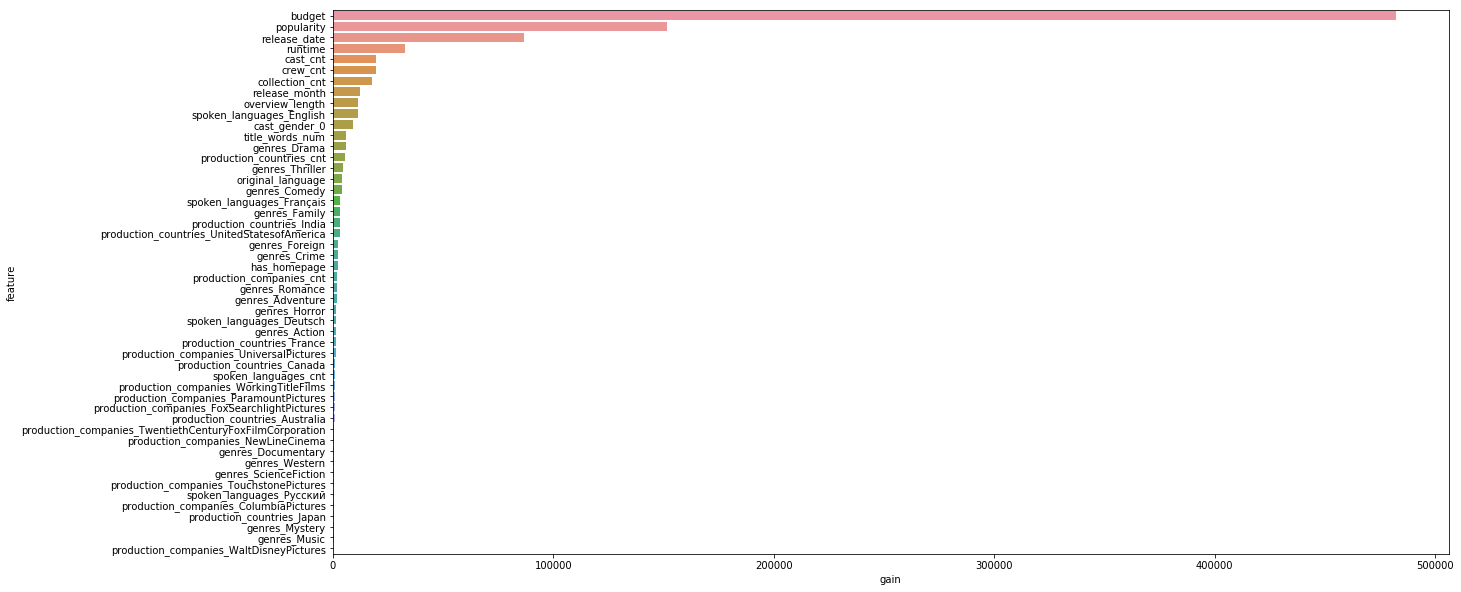

In [24]:
predict, error, imp = get_model_result(param, features, verbose = 500)
print("avg error :", error)
plt.figure(figsize=(20, 10))
sns_plot = sns.barplot(x="gain", y="feature", data=imp.head(50))
plt.savefig("imp.png")

In [25]:
submission = pd.DataFrame()
submission['id'] = df.loc[test_idx, 'id'].values.reshape(-1)
submission['revenue'] = np.expm1(predict / k)
submission.to_csv("submit_v1_st.csv", index = False)
submission.head()

,id,revenue
0,3001,1.173444e+07
1,3002,3.015203e+06
2,3003,8.967090e+06
3,3004,3.884469e+06
4,3005,6.458640e+05
